In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings(action='ignore')

## 2.2 평가방법

In [10]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression

iris = load_iris()
logreg = LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000)

### 2.2.1 홀드아웃 (hold-out)

데이터 세트 D를 겹치지 않는 임의의 두 집합(S, T)으로 나눔.   
모델은 테스트 세트 T를 활용해 오차를 측정하고, 일반화 오차에 대한 추정치를 제공.  
*훈련/테스트 세트를 나눌때 데이터 분포가 같게 나눠야함  
*분류 방법에 따라 다른 결과값을 가져옴

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(iris['data'], iris['target'], random_state=0)

In [12]:
model = logreg.fit(X_train,y_train)
score = model.score(X_test, y_test)

In [13]:
score

0.868421052631579

### 2.2.2 교차 검증 (cross validation)

데이터 세트 D를 k개 서로소 집합으로 나눔 (층화추출법)  
k-1개 데이터 세트 훈련세트로 사용. 나머지 하나 부분집합을 테스트 세트로 사용

#### 기본 KFold

In [14]:
kfold = KFold(n_splits=5)
scores = cross_val_score(logreg, iris.data, iris.target, cv=kfold)
scores, scores.mean()

(array([1.        , 0.93333333, 0.43333333, 0.96666667, 0.43333333]),
 0.7533333333333333)

iris 데이터셋은 타깃값의 순서대로 훈련 데이터가 정렬되어 있기 때문에 기본 KFold에서는 교차 검증 점수의 차이가 크게 남

#### 5차 5겹 교차 검증

In [15]:
from sklearn.model_selection import RepeatedKFold
rkfold = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
scores = cross_val_score(logreg, iris.data, iris.target, cv=rkfold)
scores, scores.mean()

(array([1.        , 0.93333333, 0.93333333, 0.96666667, 0.96666667,
        0.96666667, 0.93333333, 1.        , 1.        , 0.83333333,
        0.93333333, 0.9       , 0.96666667, 0.9       , 0.93333333,
        0.96666667, 1.        , 0.93333333, 0.93333333, 0.93333333,
        0.96666667, 0.9       , 1.        , 0.93333333, 0.93333333]),
 0.9466666666666668)

샘플 나누는 과정에서 생기는 차별을 최소화하여 교차 검증 점수가 비교적 안정됨

#### 계층별 교차 검증

In [16]:
skfold = StratifiedKFold(n_splits=5)
scores = cross_val_score(logreg, iris.data, iris.target, cv=skfold)
scores, scores.mean()

(array([1.        , 0.96666667, 0.93333333, 0.9       , 1.        ]),
 0.9600000000000002)

StratifiedKFold는 타깃값 클래스 비율을 고려하기 때문에 전체적으로 고르게 폴드를 나누어서 교차 검증 점수가 비슷함

#### LOOCV : k=m인 교차검증 (m: 데이터세트개수)

In [17]:
kfold = KFold(n_splits=150)
scores = cross_val_score(logreg, iris.data, iris.target, cv=kfold)
scores, scores.mean()

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 0.9533333333333334)

### 2.2.3 부트스트래핑

m개의 샘플이 있는 데이터 세트 D, 샘플링을 통해 데이터 D' 를 만듬.  
주로 데이터 세트가 비교적 적거나 훈련/테스트 세트로 분류하기 어려울 때 사용

In [18]:
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
sy = pd.Series(iris.target, dtype="category")
sy = sy.cat.rename_categories(iris.target_names)
iris_df['species'] = sy

In [19]:
# iterationNum: 추출 반복횟수, d: 추출 데이터 갯수
def bootstrapping(iterationNum,d,iris_df, data_columns,target_columns):
    score_list = []
    for _ in range(iterationNum):
        bootSample = iris_df.sample(d, replace=True) # 복원 추출
        testSample = pd.DataFrame() # bootSample에 속하지 않는 데이터 사용
        sample_index = set(list([item for item in bootSample.index])) 
        for i in iris_df.index:
            if (i not in sample_index):
                testSample = testSample.append(iris_df.iloc[i])

        model = logreg.fit(bootSample[data_columns],bootSample[target_columns])
        score = model.score(testSample[data_columns],testSample[target_columns])
        score_list.append(score)
    return score_list

In [20]:
score_list = bootstrapping(50,200,\
                           iris_df,
                           ['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)'],\
                           ['species'])

In [21]:
score_list = np.array(score_list)
score_list.mean()

0.9496739600025141

## 2.3 모델 성능 측정

#### 예제 
- y_true : 실제 y 값,  y_pred : y 예측 값 

In [22]:
y_true = np.array([1,1,1,1,0,0])
y_pred = np.array([1,1,0,0,0,0]) 

### 2.3.1 오차율과 정확도

- 정확도: 전체 샘플 수에서 정확히 분류한 샘플 수가 차지하는 비율
- 오차율: 모든 샘플 수에서 잘못 분류한 샘플 수가 차지하는 비율

In [23]:
accuracy = np.sum(y_true * y_pred == 1) / len(y_true)
error = 1 - accuracy

print("accuracy: "+ str(accuracy))
print("error: "+ str(error))

accuracy: 0.3333333333333333
error: 0.6666666666666667


### 2.3.2 재현율, 정밀도, F1 스코어

- confusion matrix : TP, FP, TN, FN 으로 나타냄
- precision : TP / (TP + FP)
- recall : TP / (TP + FN)

In [24]:
def fn_confusion_matrix(y_true,y_pred):
    TP = np.sum(y_true * y_pred == 1)
    FN = np.sum(y_true == 1) - TP
    FP = np.sum(y_pred == 1) - TP
    TN = np.sum((y_true == 0)) - FP
    confusion_matrix = np.array([[TP,FN],[FP,TN]])
    return confusion_matrix

In [25]:
def fn_precision(y_true,y_pred):
    TP = np.sum(y_true * y_pred == 1)
    precision = TP / np.sum(y_pred) 
    return precision

In [26]:
def fn_recall(y_true,y_pred):
    TP = np.sum(y_true * y_pred == 1)
    recall = TP / np.sum(y_true)
    return recall

In [27]:
def fn_f1_score(y_true,y_pred):
    precision = fn_precision(y_true, y_pred)
    recall = fn_recall(y_true, y_pred)
    f1 = 2 * precision*recall/(precision+recall)
    return f1

In [29]:
def fn_fbeta_score(y_true,y_pred,beta):
    precision = fn_precision(y_true, y_pred)
    recall = fn_recall(y_true, y_pred)
    fbeta = (1+np.square(beta)) * precision*recall/((np.square(beta)*precision)+recall)
    return fbeta

#### fn_confusion_matrix 결과 확인 ( sklearn.metrics.confusion_matrix 비교)

In [31]:
# 교재 표 2.1과 같이 [[TP, FN],[FP,TN]] 순서로 구성하였다.

fn_confusion_matrix(y_true,y_pred)

array([[2, 2],
       [0, 2]])

In [32]:
import sklearn.metrics 

# [[TN, FP],[FN,TP]] 순서로 confusion matrix가 구성되어있다.

sklearn.metrics.confusion_matrix(y_true,y_pred)

array([[2, 0],
       [2, 2]], dtype=int64)

#### fn_precision, fn_recall, fn_f1_score 결과 확인 ( sklearn 확인 )

In [33]:
precision = fn_precision(y_true,y_pred)
recall = fn_recall(y_true,y_pred)
f1_score = fn_f1_score(y_true,y_pred)

In [34]:
print("precision: "+ str(precision))
print("recall: "+ str(recall))
print("f1_score: "+ str(f1_score))

precision: 1.0
recall: 0.5
f1_score: 0.6666666666666666


In [35]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [36]:
print("sk_precision: "+ str(precision_score(y_true,y_pred) ))
print("sk_recall: "+ str(recall_score(y_true,y_pred) ))
print("sk_f1_score: "+ str(f1_score(y_true,y_pred) ))

sk_precision: 1.0
sk_recall: 0.5
sk_f1_score: 0.6666666666666666


### 2.3.3 ROC와 AUC

- 민감도 (Sensitivity) : (TP / TP + FN) 양성 중 맞춘 양성의 수
- 특이도 (Specificity) : (TN / FP + TN) 음성 중 맞춘 음성의 수
- 정밀도 (Precision) : (TP / TP + FP) 양성이라고 판정 한 것 중에 실제 양성 수
- 재현율 (Recall) : (TP / TP + FN) 전체 양성 수에서 검출 양성 수
- 정확도 (accuracy): (TP + TN / TP + FN + FP + TN) 전체 개수 중에서 양성과 음성을 맞춘 수

- ROC 곡선: 학습기의 일반화 성능을 나타내는 그래프
- y축 : True Positive Rate = TP / (TP + FN)
- x축 : False Positive Rate = FP / (TN+FP)

- AUC는 ROC 곡선 아래 영역

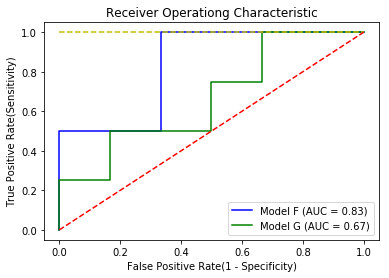

In [37]:
# ROC를 통해 Model F와 Model G의 성능 비교

from sklearn.metrics import roc_curve, auc

class_F = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1])
proba_F = np.array([0.05, 0.15, 0.15, 0.25, 0.55, 0.65, 0.35, 0.45, 0.95, 0.95])

class_G = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1])
proba_G = np.array([0.05, 0.05, 0.25, 0.45, 0.65, 0.85, 0.15, 0.35, 0.75, 0.95])

false_positive_rate_F, true_positive_rate_F, thresholds_F = roc_curve(class_F, proba_F)
false_positive_rate_G, true_positive_rate_G, thresholds_G = roc_curve(class_G, proba_G)

roc_auc_F = auc(false_positive_rate_F, true_positive_rate_F)
roc_auc_G = auc(false_positive_rate_G, true_positive_rate_G)

plt.title('Receiver Operationg Characteristic')
plt.xlabel('False Positive Rate(1 - Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')

plt.plot(false_positive_rate_F, true_positive_rate_F, 'b', label='Model F (AUC = %0.2f)'%roc_auc_F)
plt.plot(false_positive_rate_G, true_positive_rate_G, 'g', label='Model G (AUC = %0.2f)'%roc_auc_G)

plt.plot([0,1],[1,1], 'y--')
plt.plot([0,1],[0,1], 'r--')

plt.legend(loc = 'lower right')
plt.show()